In [1]:
# imports
import os
import sys

import numpy as np
import pandas as pd
import scanpy as sc
import mudata
from anndata import AnnData
from mudata import MuData
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib_venn import venn3


def get_target_vs_nontarget_expr(
    mdata: MuData,
    guide_id: str,
    gene_id: str,
    guide_mod: str = "guide",
    gene_mod: str = "gene",
    gene_layer: str = None,
    guide_assignment_layer: str = "guide_assignment",
    non_targeting_label: str = "non_targeting",
) -> pd.DataFrame:
    """
    Return a long-format expression DataFrame for a given guide and gene, with
    one row per cell and columns: ["expression", "group"].

    Parameters
    ----------
    mdata
        MuData object with a guide modality and a gene-expression modality.
    guide_id
        The guide identifier (must be a column in guide.var_names).
    gene_id
        The gene identifier (must be a column in gene.var_names).
    guide_mod
        Key for the guide modality in mdata.mod.
    gene_mod
        Key for the gene-expression modality in mdata.mod.
    guide_assignment_layer
        Name of the layer in the guide AnnData containing guide assignments.
    non_targeting_label
        Value in guide.var["label"] that marks non-targeting guides.

    Returns
    -------
    expr_df : pandas.DataFrame
        Columns:
            - "expression": expression values of `gene_id`
            - "group": "targeting" group labelled by `guide_id`
                       and "non_targeting" group labelled by `non_targeting_label`
    """
    # ----- Pull out modalities -----
    guide: AnnData = mdata.mod[guide_mod]
    gene: AnnData = mdata.mod[gene_mod]

    # Basic checks
    if guide_id not in guide.var_names:
        raise ValueError(f"guide_id `{guide_id}` not found in guide.var_names")
    if gene_id not in gene.var_names:
        raise ValueError(f"gene_id `{gene_id}` not found in gene.var_names")
    if "label" not in guide.var.columns:
        raise ValueError("guide.var must contain a 'label' column")

    # ----- Get expression vector for the gene -----
    # sc.get.obs_df returns a DataFrame with index = cells, col = gene(s)
    gene_expr_df = sc.get.obs_df(gene, keys=[gene_id], layer=gene_layer)
    # Convert to a 1D Series for convenience
    gene_expr = gene_expr_df[gene_id]

    # ----- Cells with the specific guide (targeting group) -----
    guide_assign = sc.get.obs_df(
        guide,
        keys=[guide_id],
        layer=guide_assignment_layer,
    )
    # single-column DataFrame; treat > 0 as "has this guide"
    bc_with_guide = guide_assign[guide_id] > 0
    bc_with_guide = guide_assign.index[bc_with_guide].tolist()

    # ----- Cells with any non-targeting guide -----
    nt_guide_idx = guide.var.index[guide.var["label"] == non_targeting_label].tolist()
    if len(nt_guide_idx) == 0:
        raise ValueError(f"No guides with label `{non_targeting_label}` found in guide.var['label'].")

    nt_guide_assign = sc.get.obs_df(
        guide,
        keys=nt_guide_idx,
        layer=guide_assignment_layer,
    )
    bc_with_nt = nt_guide_assign[nt_guide_assign.sum(axis=1) > 0].index.tolist()

    # ----- Cells with any *non*-non-targeting guide -----
    non_nt_guide_idx = guide.var.index[guide.var["label"] != non_targeting_label].tolist()
    non_nt_guide_assign = sc.get.obs_df(
        guide,
        keys=non_nt_guide_idx,
        layer=guide_assignment_layer,
    )
    bc_with_non_nt = non_nt_guide_assign[non_nt_guide_assign.sum(axis=1) > 0].index.tolist()

    # Keep only barcodes that have *only* non-targeting guides (no targeting guides at all)
    bc_nt_only = list(set(bc_with_nt) - set(bc_with_non_nt))

    # ----- Subset expression -----
    target_expr = gene_expr.loc[bc_with_guide]
    nontarget_expr = gene_expr.loc[bc_nt_only]

    # ----- Build long-format DataFrame -----
    expr_df = pd.DataFrame(
        {
            "expression": pd.concat([target_expr, nontarget_expr]),
            "group": (
                [guide_id] * len(target_expr)
                + [non_targeting_label] * len(nontarget_expr)
            ),
        },
        index=pd.Index(
            target_expr.index.tolist() + nontarget_expr.index.tolist(),
            name="barcode",
        ),
    )

    return expr_df

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
path_mdata = "/cellar/users/aklie/data/datasets/tf_perturb_seq/datasets/Huangfu_WTC11-benchmark_TF-Perturb-seq/results/1_CRISPR_pipeline/2025_12_16/inference_mudata.h5mu"

path_out = "/cellar/users/aklie/data/datasets/tf_perturb_seq/datasets/Huangfu_WTC11-benchmark_TF-Perturb-seq/results/2_qc/2025_12_16/inference_qc"

os.makedirs(path_out, exist_ok=True)

In [3]:
dataset = path_mdata.split("/")[-5]  # Gersbach_WTC11-benchmark_TF-Perturb-seq_GEM-Xv3
lab = dataset.replace("_WTC11-benchmark_TF-Perturb-seq", "")
print(f"Processing dataset: {dataset} (label: {lab})")

Processing dataset: Huangfu_WTC11-benchmark_TF-Perturb-seq (label: Huangfu)


# Load MuData

In [14]:
mdata = mudata.read_h5mu(path_mdata)
mdata

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


MuData object with n_obs × n_vars = 114489 × 9390
  obs:	'batch', 'cov1'
  uns:	'per_element_results', 'per_guide_results'
  2 modalities
    gene:	114489 x 8974
      obs:	'batch', 'cov1', 'batch_number', 'n_counts', 'log1p_n_genes_by_counts', 'total_gene_umis', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'percent_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'num_expressed_genes'
      var:	'symbol', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'gene_chr', 'gene_start', 'gene_end'
    guide:	114489 x 416
      obs:	'batch', 'cov1', 'num_expressed_guides', 'total_guide_umis'
      var:	'guide_id', 'spacer', 'targeting', 'type', 'guide_chr', 'guide_start', 'guide_end', 'strand', 'pam', 'genomic_element', 'intended_target_name', 'intended_target_chr', 'intended_target_start', 'intended_target_end', 'putative_target_genes', 'reporter', 'imperfect', 'gene_name', 'label'
      uns:	'capture_method', 'moi'
      layers:	'guide_assignment'

In [15]:
mdata.mod["guide"].var

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,genomic_element,intended_target_name,intended_target_chr,intended_target_start,intended_target_end,putative_target_genes,reporter,imperfect,gene_name,label
guide_id,,,,,,,,,,,,,,,,,,,
CD81#strong,CD81#strong,GAGAGCGAGCGCGCAACGG,True,positive control,chr11,2377315.0,2377333.0,+,NGG,promoter,ENSG00000110651,chr11,2377315.0,2377333.0,NaN,NaN,NaN,CD81,positive_control
CD81#weak,CD81#weak,GAGAGCCAGCGCGCAACGG,True,positive control,chr11,2377315.0,2377333.0,+,NGG,promoter,ENSG00000110651,chr11,2377315.0,2377333.0,NaN,NaN,NaN,CD81,positive_control
CD151#strong,CD151#strong,CCGGACTCGGACGCGTGGT,True,positive control,chr11,833006.0,833024.0,+,NGG,promoter,ENSG00000177697,chr11,833006.0,833024.0,NaN,NaN,NaN,CD151,positive_control
CD151#weak,CD151#weak,CCGCTCGGCCGAGCTGTCG,True,positive control,chr11,833006.0,833024.0,+,NGG,promoter,ENSG00000177697,chr11,833006.0,833024.0,NaN,NaN,NaN,CD151,positive_control
CD55#strong,CD55#strong,CTGCGACTCGGCGGAGTCC,True,positive control,chr1,207321714.0,207321732.0,+,NGG,promoter,ENSG00000196352,chr1,207321714.0,207321732.0,NaN,NaN,NaN,CD55,positive_control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TFCP2L1#chr2:121284700-121284718(+),TFCP2L1#chr2:121284700-121284718(+),CGATACGCGGGGGAGAGGA,True,targeting,chr2,121284700.0,121284718.0,+,NGG,promoter,ENSG00000115112,chr2,121284700.0,121285179.0,NaN,NaN,NaN,TFCP2L1,tf_targeting
TFCP2L1#chr2:121285141-121285159(+),TFCP2L1#chr2:121285141-121285159(+),CGGCAGCAAGCGCAGACGC,True,targeting,chr2,121285141.0,121285159.0,+,NGG,promoter,ENSG00000115112,chr2,121284700.0,121285179.0,NaN,NaN,NaN,TFCP2L1,tf_targeting
TFCP2L1#chr2:121284796-121284814(+),TFCP2L1#chr2:121284796-121284814(+),AGGAGCCCTCGCAGACATA,True,targeting,chr2,121284796.0,121284814.0,+,NGG,promoter,ENSG00000115112,chr2,121284700.0,121285179.0,NaN,NaN,NaN,TFCP2L1,tf_targeting


In [5]:
# Preprocess gene expression data
mdata.mod["gene"].layers["counts"] = mdata.mod["gene"].X.copy()
sc.pp.normalize_total(mdata.mod["gene"], target_sum=1e4)
sc.pp.log1p(mdata.mod["gene"])

In [6]:
guide_meta = mdata.mod["guide"].var.copy()
guide_meta.reset_index(inplace=True, drop=True)
guide_meta.head()

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,genomic_element,intended_target_name,intended_target_chr,intended_target_start,intended_target_end,putative_target_genes,reporter,imperfect,gene_name,label
0,CD81#strong,GAGAGCGAGCGCGCAACGG,True,positive control,chr11,2377315.0,2377333.0,+,NGG,promoter,ENSG00000110651,chr11,2377315.0,2377333.0,NaN,NaN,NaN,CD81,positive_control
1,CD81#weak,GAGAGCCAGCGCGCAACGG,True,positive control,chr11,2377315.0,2377333.0,+,NGG,promoter,ENSG00000110651,chr11,2377315.0,2377333.0,NaN,NaN,NaN,CD81,positive_control
2,CD151#strong,CCGGACTCGGACGCGTGGT,True,positive control,chr11,833006.0,833024.0,+,NGG,promoter,ENSG00000177697,chr11,833006.0,833024.0,NaN,NaN,NaN,CD151,positive_control
3,CD151#weak,CCGCTCGGCCGAGCTGTCG,True,positive control,chr11,833006.0,833024.0,+,NGG,promoter,ENSG00000177697,chr11,833006.0,833024.0,NaN,NaN,NaN,CD151,positive_control
4,CD55#strong,CTGCGACTCGGCGGAGTCC,True,positive control,chr1,207321714.0,207321732.0,+,NGG,promoter,ENSG00000196352,chr1,207321714.0,207321732.0,NaN,NaN,NaN,CD55,positive_control


In [7]:
# Get a map for the intended targets
id_map = mdata.mod["guide"].var.set_index("intended_target_name")["gene_name"]
id_map = id_map[~id_map.index.duplicated(keep="first")]
id_map

intended_target_name
ENSG00000110651       CD81
ENSG00000177697      CD151
ENSG00000196352       CD55
ENSG00000166681    NGFRAP1
ENSG00000072274       TFRC
                    ...   
ENSG00000140262      TCF12
ENSG00000152284     TCF7L1
ENSG00000148737     TCF7L2
ENSG00000081059       TCF7
ENSG00000115112    TFCP2L1
Name: gene_name, Length: 61, dtype: category
Categories (61, object): ['AFF4', 'ARID1A', 'ARID1B', 'ARNT', ..., 'TCF12', 'TFCP2L1', 'TFRC', 'non-targeting']

# Cis analysis per guide

In [8]:
# Load res at guide level
#cis_res_guide = mdata.uns["cis_per_guide_results"]
cis_res_guide = pd.read_csv("/cellar/users/aklie/data/datasets/tf_perturb_seq/datasets/Huangfu_WTC11-benchmark_TF-Perturb-seq/results/1_CRISPR_pipeline/2025_12_16/perturbo_cis_per_guide_output.tsv.gz", sep="\t")

# Add in intended target gene name
cis_res_guide["gene_name"] = cis_res_guide["gene_id"].map(id_map)

# add target name from guide_id
cis_res_guide["target_name"] = cis_res_guide["guide_id"].str.split("#").str[0]

# Keep only those with gene_name and target_name same
cis_res_guide_intended = cis_res_guide[cis_res_guide["gene_name"] == cis_res_guide["target_name"]]

# Deduplicate
cis_res_guide_intended = cis_res_guide_intended.drop_duplicates(subset=["guide_id", "gene_id"])

# Merge in guide metadata
#cis_res_guide_intended = guide_meta.merge(cis_res_guide_intended[["guide_id", "log2_fc", "p_value", "perturbo_log2_fc", "perturbo_p_value"]], left_on="guide_id", right_on="guide_id", how="left")
cis_res_guide_intended = guide_meta.merge(cis_res_guide_intended[["guide_id", "log2_fc", "p_value"]], left_on="guide_id", right_on="guide_id", how="left")

# Head
cis_res_guide_intended.head()

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,genomic_element,...,intended_target_chr,intended_target_start,intended_target_end,putative_target_genes,reporter,imperfect,gene_name,label,log2_fc,p_value
0,CD81#strong,GAGAGCGAGCGCGCAACGG,True,positive control,chr11,2377315.0,2377333.0,+,NGG,promoter,...,chr11,2377315.0,2377333.0,NaN,NaN,NaN,CD81,positive_control,-2.157151,6.446119e-129
1,CD81#weak,GAGAGCCAGCGCGCAACGG,True,positive control,chr11,2377315.0,2377333.0,+,NGG,promoter,...,chr11,2377315.0,2377333.0,NaN,NaN,NaN,CD81,positive_control,-1.951508,9.953291e-171
2,CD151#strong,CCGGACTCGGACGCGTGGT,True,positive control,chr11,833006.0,833024.0,+,NGG,promoter,...,chr11,833006.0,833024.0,NaN,NaN,NaN,CD151,positive_control,NaN,NaN
3,CD151#weak,CCGCTCGGCCGAGCTGTCG,True,positive control,chr11,833006.0,833024.0,+,NGG,promoter,...,chr11,833006.0,833024.0,NaN,NaN,NaN,CD151,positive_control,NaN,NaN
4,CD55#strong,CTGCGACTCGGCGGAGTCC,True,positive control,chr1,207321714.0,207321732.0,+,NGG,promoter,...,chr1,207321714.0,207321732.0,NaN,NaN,NaN,CD55,positive_control,-2.445940,1.089320e-31


NGFRAP1#A -2.355461 0.0
TFRC#A -1.9892117 2.703990157761241e-199
CD81#weak -1.9515084 9.953291195945669e-171
CD81#strong -2.1571507 6.446118786912221e-129
NGFRAP1#B -1.5663488 1.1482511564096021e-109
TCF7L1#chr2:85133442-85133460(+) -0.92880493 9.121728549181174e-75
TCF7L2#chr10:112950246-112950264(-) -1.1383458 4.981062150902586e-66
TCF7L2#chr10:112950277-112950295(-) -1.3276728 9.199591737662733e-65
SMARCC1#chr3:47781383-47781401(+) -1.79806 5.4999345174578245e-62
SMARCC1#chr3:47781854-47781872(-) -1.5194005 7.604414641389111e-62


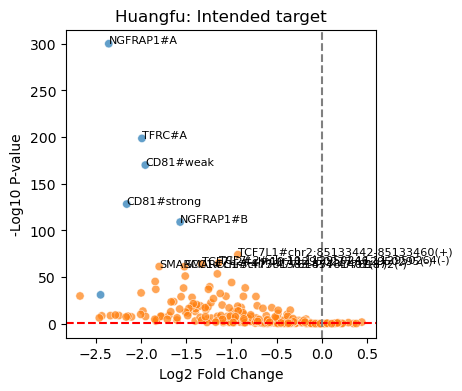

In [9]:
# Make a volcano plot of perturb_log2_fc vs -log10(p_value), color by label
# Label the top 10 guides by -log10(p_value)
cis_res_guide_intended["label"] = cis_res_guide_intended["label"].astype(str)
plot_data = cis_res_guide_intended.copy()
plot_data = plot_data.dropna(subset=["log2_fc", "p_value"])

plt.figure(figsize=(4, 4))
sns.scatterplot(data=plot_data, x="log2_fc", y=-np.log10(plot_data["p_value"] + 1e-300), hue="label", alpha=0.7)
top10 = plot_data.nsmallest(10, "p_value")
for _, row in top10.iterrows():
    print(row["guide_id"], row["log2_fc"], row["p_value"])
    plt.text(row["log2_fc"], -np.log10(row["p_value"] + 1e-300), row["guide_id"], fontsize=8)
plt.title(f"{lab}: Intended target")
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10 P-value")
plt.axhline(-np.log10(0.05), color='red', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
#plt.legend(title="Label", loc="center left")
# remove legend
plt.legend([],[], frameon=False)
#plt.tight_layout()

# Save plot
plt.savefig(os.path.join(path_out, f"{dataset}_perturbo-cis-intended-target_volcano.png"), dpi=300)
plot_data[["guide_id", "gene_name", "log2_fc", "p_value"]].rename(columns={
    "log2_fc": "log2_fc",
    "p_value": "p_value",
}).to_csv(os.path.join(path_out, f"{dataset}_perturbo-cis-intended-target_results.tsv"), index=False, sep="\t")

In [13]:
guide.var

NameError: name 'guide' is not defined

In [12]:
plot_data[plot_data["label"] == "positive_control"]

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,genomic_element,...,intended_target_chr,intended_target_start,intended_target_end,putative_target_genes,reporter,imperfect,gene_name,label,log2_fc,p_value
0,CD81#strong,GAGAGCGAGCGCGCAACGG,True,positive control,chr11,2377315.0,2377333.0,+,NGG,promoter,...,chr11,2377315.0,2377333.0,NaN,NaN,NaN,CD81,positive_control,-2.157151,6.446119e-129
1,CD81#weak,GAGAGCCAGCGCGCAACGG,True,positive control,chr11,2377315.0,2377333.0,+,NGG,promoter,...,chr11,2377315.0,2377333.0,NaN,NaN,NaN,CD81,positive_control,-1.951508,9.953291e-171
4,CD55#strong,CTGCGACTCGGCGGAGTCC,True,positive control,chr1,207321714.0,207321732.0,+,NGG,promoter,...,chr1,207321714.0,207321732.0,NaN,NaN,NaN,CD55,positive_control,-2.445940,1.089320e-31
5,NGFRAP1#B,GTTGGAGTTTGCCCTCCTC,True,positive control,chrX,103376261.0,103376279.0,-,NGG,promoter,...,chrX,103376258.0,103376279.0,NaN,NaN,NaN,NGFRAP1,positive_control,-1.566349,1.148251e-109
6,NGFRAP1#A,AGGACCGAGAAGAGTGACA,True,positive control,chrX,103376320.0,103376338.0,+,NGG,promoter,...,chrX,103376320.0,103376338.0,NaN,NaN,NaN,NGFRAP1,positive_control,-2.355461,0.000000e+00
7,TFRC#A,CTCAGAGCGTCGGGATATC,True,positive control,chr3,196082075.0,196082093.0,-,NGG,promoter,...,chr3,196082072.0,196082093.0,NaN,NaN,NaN,TFRC,positive_control,-1.989212,2.703990e-199


In [13]:
num_tests = cis_res_guide_intended.shape[0]

# How many had a 60% knockdown or more?
fc_threshold = 0.4
log2fc_threshold = np.log2(fc_threshold)
strong_knockdowns = cis_res_guide_intended[cis_res_guide_intended["log2_fc"] <= log2fc_threshold]
num_strong_knockdowns = len(strong_knockdowns)
print(f"Number of guides with at least {int((1-fc_threshold)*100)}% knockdown: {num_strong_knockdowns} out of {num_tests} tests ({num_strong_knockdowns/num_tests*100:.2f}%)")
strong_knockdowns[["guide_id", "gene_name", "log2_fc", "p_value"]].rename(columns={
    "log2_fc": "log2_fc",
    "p_value": "p_value",
}).to_csv(os.path.join(path_out, f"{dataset}_perturbo-cis-intended-target_strong-knockdowns-fc-{fc_threshold}.tsv"), index=False, sep="\t")

# How many where significant at 0.05 level?
pval_threshold = 0.05
significant = cis_res_guide_intended[cis_res_guide_intended["p_value"] < pval_threshold]
num_significant = len(significant)
print(f"Number of guides significant at p<{pval_threshold}: {num_significant} out of {num_tests} tests ({num_significant/num_tests*100:.2f}%)")
significant[["guide_id", "gene_name", "log2_fc", "p_value"]].rename(columns={
    "log2_fc": "log2_fc",
    "p_value": "p_value",
}).to_csv(os.path.join(path_out, f"{dataset}_perturbo-cis-intended-target_significant-pval-{pval_threshold}.tsv"), index=False, sep="\t")

Number of guides with at least 60% knockdown: 54 out of 416 tests (12.98%)
Number of guides significant at p<0.05: 168 out of 416 tests (40.38%)


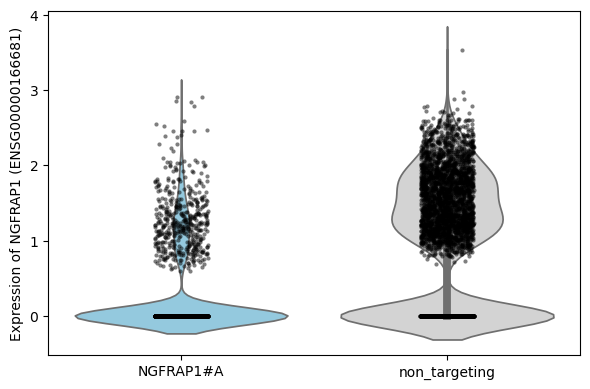

In [15]:
ind = 0
sorted_res = cis_res_guide_intended.sort_values("p_value")
guide_id = sorted_res.iloc[ind]["guide_id"]
target_id = sorted_res.iloc[ind]["intended_target_name"]
gene_name = id_map[target_id]

expr_df = get_target_vs_nontarget_expr(
    mdata,
    guide_id=guide_id,
    gene_id=target_id,
)

# Plot and color non-targeting vs targeting differently
plt.figure(figsize=(6, 4))
sns.violinplot(data=expr_df, x="group", y="expression", hue="group", palette={"non_targeting": "lightgrey", guide_id: "skyblue"})
sns.stripplot(data=expr_df, x="group", y="expression", color="k", size=3, alpha=0.5)
plt.ylabel(f"Expression of {gene_name} ({target_id})")
plt.xlabel(f"")
plt.tight_layout()

# Trans analysis

## Intended targets only

In [30]:
# Load res at guide level
#trans_res_guide = mdata.uns["per_guide_results"]
trans_res_guide = pd.read_csv("/cellar/users/aklie/data/datasets/tf_perturb_seq/datasets/Huangfu_WTC11-benchmark_TF-Perturb-seq/results/1_CRISPR_pipeline/2025_11_26/perturbo_trans_per_guide_output.tsv.gz", sep="\t")

# Add in intended target gene name
trans_res_guide["gene_name"] = trans_res_guide["gene_id"].map(id_map)

# add target name from guide_id
trans_res_guide["target_name"] = trans_res_guide["guide_id"].str.split("#").str[0]

# Keep only those with gene_name and target_name same
trans_res_guide_intended = trans_res_guide[trans_res_guide["gene_name"] == trans_res_guide["target_name"]]

# Deduplicate
trans_res_guide_intended = trans_res_guide_intended.drop_duplicates(subset=["guide_id", "gene_id"])

# Merge in guide metadata
trans_res_guide_intended = guide_meta.merge(trans_res_guide_intended[["guide_id", "log2_fc", "p_value"]], left_on="guide_id", right_on="guide_id", how="left")

# Head
trans_res_guide_intended.head()

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,PAM,intended_target_name,intended_target_chr,intended_target_start,intended_target_end,gene_name,label,log2_fc,p_value
0,CD81#weak,GAGAGCCAGCGCGCAACGG,True,targeting,chr11,2377315.0,2377333.0,+,NGG,ENSG00000110651,chr11,2377315.0,2377333.0,CD81,positive_control,-0.252540,0.059062
1,CD151#strong,CCGGACTCGGACGCGTGGT,True,targeting,chr11,833006.0,833024.0,+,NGG,ENSG00000177697,chr11,833006.0,833024.0,CD151,positive_control,NaN,NaN
2,CD151#weak,CCGCTCGGCCGAGCTGTCG,True,targeting,chr11,833006.0,833024.0,+,NGG,ENSG00000177697,chr11,833006.0,833024.0,CD151,positive_control,NaN,NaN
3,CD55#strong,CTGCGACTCGGCGGAGTCC,True,targeting,chr1,207321714.0,207321732.0,+,NGG,ENSG00000196352,chr1,207321714.0,207321732.0,CD55,positive_control,-0.186520,0.418572
4,NGFRAP1#B,GTTGGAGTTTGCCCTCCTC,True,targeting,chrX,103376258.0,103376279.0,-,NGG,ENSG00000166681,chrX,103376258.0,103376279.0,NGFRAP1,positive_control,-0.276697,0.114231


CREBBP#chr16:3880675-3880693(+) -0.6415044 1.6257091512255073e-15
CREBBP#chr16:3880623-3880641(+) 0.3866762 8.410547697981223e-08
HMGA2#chr12:65825083-65825101(-) 0.39785397 2.647077245799542e-07
TCF7L1#chr2:85133442-85133460(+) -0.2691066 2.989657966437214e-07
SMARCC1#chr3:47781489-47781507(-) 0.2728865 4.800305953506781e-07
TCF12#chr15:57219458-57219476(+) 0.22743261 2.2772900808649102e-06
ARNT#chr1:150876336-150876354(-) -1.284357 2.9459068421424448e-06
REST#chr4:56908979-56908997(+) 0.23820266 4.918798596554218e-06
TCF7L1#chr2:85133581-85133599(+) -0.21194229 0.0001295570664478
SMARCD1#chr12:50085236-50085254(-) -0.64116955 0.0002455337189099


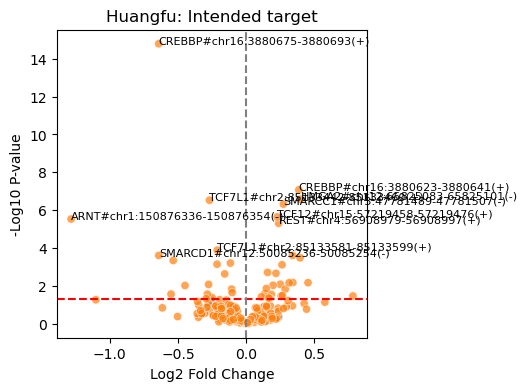

In [31]:
# Make a volcano plot of perturb_log2_fc vs -log10(p_value), color by label
# Label the top 10 guides by -log10(p_value)
trans_res_guide_intended["label"] = trans_res_guide_intended["label"].astype(str)
plot_data = trans_res_guide_intended.copy()
plot_data = plot_data.dropna(subset=["log2_fc", "p_value"])

plt.figure(figsize=(4, 4))
sns.scatterplot(data=plot_data, x="log2_fc", y=-np.log10(plot_data["p_value"] + 1e-300), hue="label", alpha=0.7)
top10 = plot_data.nsmallest(10, "p_value")
for _, row in top10.iterrows():
    print(row["guide_id"], row["log2_fc"], row["p_value"])
    plt.text(row["log2_fc"], -np.log10(row["p_value"] + 1e-300), row["guide_id"], fontsize=8)
plt.title(f"{lab}: Intended target")
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10 P-value")
plt.axhline(-np.log10(0.05), color='red', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
#plt.legend(title="Label")
plt.legend([],[], frameon=False)

#plt.tight_layout()

# Save plot
plt.savefig(os.path.join(path_out, f"{dataset}_perturbo-trans-intended-target_volcano.png"), dpi=300)
plot_data[["guide_id", "gene_name", "log2_fc", "p_value"]].rename(columns={
    "log2_fc": "log2_fc",
    "p_value": "p_value",
}).to_csv(os.path.join(path_out, f"{dataset}_perturbo-trans-intended-target_results.tsv"), index=False, sep="\t")

In [32]:
num_tests = trans_res_guide_intended.shape[0]

# Save strong knockdowns
fc_threshold = 0.4
log2fc_threshold = np.log2(fc_threshold)
strong_knockdowns = trans_res_guide_intended[trans_res_guide_intended["log2_fc"] <= log2fc_threshold]
num_strong_knockdowns = len(strong_knockdowns)
print(f"Number of guides with at least {int((1-fc_threshold)*100)}% knockdown: {num_strong_knockdowns} out of {num_tests} tests ({num_strong_knockdowns/num_tests*100:.2f}%)")
strong_knockdowns[["guide_id", "gene_name", "log2_fc", "p_value"]].rename(columns={
    "log2_fc": "log2_fc",
    "p_value": "p_value",
}).to_csv(os.path.join(path_out, f"{dataset}_perturbo-trans-intended-target_strong_knockdowns.tsv"), index=False, sep="\t")

# How many where significant at 0.05 level?
pval_threshold = 0.05
significant = trans_res_guide_intended[trans_res_guide_intended["p_value"] < pval_threshold]
num_significant = len(significant)
print(f"Number of guides significant at p<{pval_threshold}: {num_significant} out of {num_tests} tests ({num_significant/num_tests*100:.2f}%)")
significant[["guide_id", "gene_name", "log2_fc", "p_value"]].rename(columns={
    "log2_fc": "log2_fc",
    "p_value": "p_value",
}).to_csv(os.path.join(path_out, f"{dataset}_perturbo-trans-intended-target_significant.tsv"), index=False, sep="\t")

Number of guides with at least 60% knockdown: 0 out of 415 tests (0.00%)
Number of guides significant at p<0.05: 42 out of 415 tests (10.12%)


/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


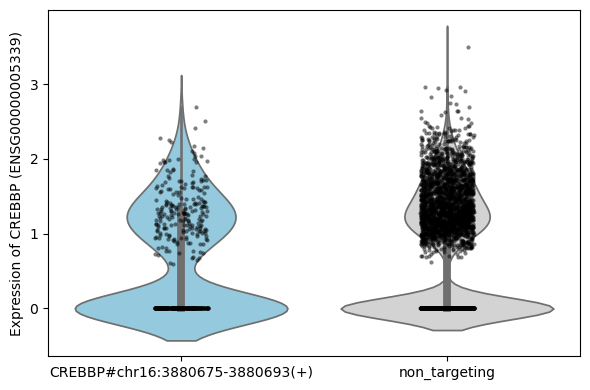

In [33]:
ind = 0
sorted_res = trans_res_guide_intended.sort_values("p_value")
guide_id = sorted_res.iloc[ind]["guide_id"]
target_id = sorted_res.iloc[ind]["intended_target_name"]
gene_name = id_map[target_id]

expr_df = get_target_vs_nontarget_expr(
    mdata,
    guide_id=guide_id,
    gene_id=target_id,
)

# Plot and color non-targeting vs targeting differently
plt.figure(figsize=(6, 4))
sns.violinplot(data=expr_df, x="group", y="expression", hue="group", palette={"non_targeting": "lightgrey", guide_id: "skyblue"})
sns.stripplot(data=expr_df, x="group", y="expression", color="k", size=3, alpha=0.5)
plt.ylabel(f"Expression of {gene_name} ({target_id})")
plt.xlabel(f"")
plt.tight_layout()

## Trans effects

In [53]:
# Deduplicate
trans_res_guide = trans_res_guide.drop_duplicates(subset=["guide_id", "gene_id"])

# Merge in guide metadata
trans_res_guide = guide_meta.merge(trans_res_guide[["guide_id", "log2_fc", "p_value"]], left_on="guide_id", right_on="guide_id", how="left")

# Head
trans_res_guide.head()

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,PAM,intended_target_name,intended_target_chr,intended_target_start,intended_target_end,gene_name,label,log2_fc,p_value
0,CD81#weak,CCGTTGCGCGCTGGCTCTC,True,targeting,chr11,2377315.0,2377333.0,+,NGG,ENSG00000110651,chr11,2377315.0,2377333.0,CD81,positive_control,0.017092,0.729835
1,CD81#weak,CCGTTGCGCGCTGGCTCTC,True,targeting,chr11,2377315.0,2377333.0,+,NGG,ENSG00000110651,chr11,2377315.0,2377333.0,CD81,positive_control,0.111755,0.076803
2,CD81#weak,CCGTTGCGCGCTGGCTCTC,True,targeting,chr11,2377315.0,2377333.0,+,NGG,ENSG00000110651,chr11,2377315.0,2377333.0,CD81,positive_control,-0.026427,0.614363
3,CD81#weak,CCGTTGCGCGCTGGCTCTC,True,targeting,chr11,2377315.0,2377333.0,+,NGG,ENSG00000110651,chr11,2377315.0,2377333.0,CD81,positive_control,0.098865,0.005546
4,CD81#weak,CCGTTGCGCGCTGGCTCTC,True,targeting,chr11,2377315.0,2377333.0,+,NGG,ENSG00000110651,chr11,2377315.0,2377333.0,CD81,positive_control,0.053253,0.199783


CD81#weak -2.0226414 0.0
NGFRAP1#A -2.0817137 0.0
HIF1A#chr14:61695605-61695623(-) -1.4757324 0.0
REST#chr4:56907913-56907931(+) 3.8237746 0.0
REST#chr4:56907913-56907931(+) 3.892902 1.1720169351281202e-279
HIF1A#chr14:61695530-61695548(-) -1.8736569 2.982946075855868e-273
CTNNB1#chr3:41199530-41199548(+) 4.2089243 1.1996286022465605e-252
CTNNB1#chr3:41199530-41199548(+) -1.7202677 7.094855719007844e-238
CTNNB1#chr3:41199530-41199548(+) 3.3938503 1.1666083582416803e-205
SUZ12#chr17:31937142-31937160(-) 3.2155633 3.661143849868938e-205


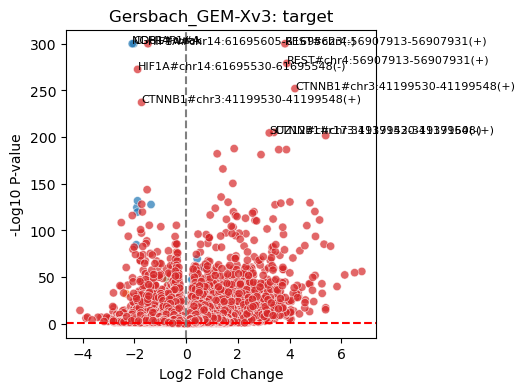

In [54]:
# Make a volcano plot of perturb_log2_fc vs -log10(p_value), color by label
# Label the top 10 guides by -log10(p_value)
trans_res_guide["label"] = trans_res_guide["label"].astype(str)
plot_data = trans_res_guide.copy()
plot_data = plot_data.dropna(subset=["log2_fc", "p_value"])

plt.figure(figsize=(4, 4))
sns.scatterplot(data=plot_data, x="log2_fc", y=-np.log10(plot_data["p_value"] + 1e-300), hue="label", alpha=0.7)

plt.title(f"{lab}: target")
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10 P-value")
plt.axhline(-np.log10(0.05), color='red', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.legend(title="Label")

#plt.tight_layout()

In [ ]:
# Save plot
plt.savefig(os.path.join(path_out, f"{dataset}_perturbo-trans-target_volcano.png"), dpi=300)
plot_data[["guide_id", "gene_name", "log2_fc", "p_value"]].rename(columns={
    "log2_fc": "log2_fc",
    "p_value": "p_value",
}).to_csv(os.path.join(path_out, f"{dataset}_perturbo-trans-target_results.tsv"), index=False, sep="\t")

# DONE!

---


In [ ]:
# 
guide = mdata.mod["guide"]
gene = mdata.mod["gene"]

# get barcodes with CD81#weak guide
guide_assign = sc.get.obs_df(guide, keys="CD81#weak", layer="guide_assignment")
bc_w_guide = guide_assign[guide_assign > 0].index.tolist()

# get expression of ENSG00000110651 from gene
gene_expr = sc.get.obs_df(gene, keys="ENSG00000110651")
guide_expr = gene_expr.loc[bc_w_guide]

# Get barcodes with any non-targeting guide
nt_guide_idx = guide.var[guide.var["label"] == "non_targeting"].index.tolist()
nt_guide_assign = sc.get.obs_df(guide, keys=nt_guide_idx, layer="guide_assignment")
bc_w_nt_guide = nt_guide_assign[nt_guide_assign.sum(axis=1) > 0].index.tolist()

# Get barcodes with any guide that isn't non-targeting
non_nt_guide_idx = guide.var[guide.var["label"] != "non_targeting"].index.tolist()
non_nt_guide_assign = sc.get.obs_df(guide, keys=non_nt_guide_idx, layer="guide_assignment")
bc_w_non_nt_guide = non_nt_guide_assign[non_nt_guide_assign.sum(axis=1) > 0].index.tolist()

# Get only those with non-targeting guides
bc_w_nt_guide = list(set(bc_w_nt_guide) - set(bc_w_non_nt_guide))

# Get expression of ENSG00000110651 for these barcodes
nt_guide_expr = gene_expr.loc[bc_w_nt_guide]

# Plot a violin plot comparing expression of ENSG00000110651 between CD81#weak guide and non-targeting guides
expr_df = pd.DataFrame({
    "expression": pd.concat([guide_expr, nt_guide_expr]),
    "group": ["CD81#weak"] * len(guide_expr) + ["non_targeting"] * len(nt_guide_expr)
})

plt.figure(figsize=(6, 6))
sns.violinplot(data=expr_df, x="group", y="expression", inner="box")
plt.title("Expression of ENSG00000110651 by Guide Group")
plt.ylabel("Expression Level")
plt.xlabel("Guide Group")
plt.tight_layout()

In [279]:
import os
import pandas as pd
import numpy as np
import muon as mu
from mudata import MuData
import networkx as nx
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Any, Optional


def plot_network(
    results_df: Optional[pd.DataFrame],
    central_node: Optional[str] = None,
    source_column: str = "source",
    target_column: str = "target",
    weight_column: Optional[str] = None,
    min_weight: Optional[float] = None,
    node_size_column: Optional[str] = None,
    
):
    # Get and filter the results dataframe
    if min_weight is not None:
        results_df = results_df[results_df[weight_column].abs() >= min_weight]
    if central_node is not None:
        results_df = results_df[results_df[source_column] == central_node]

    # Create the network 
    G = nx.DiGraph()
    for i, row in results_df.iterrows():
        G.add_edge(row[source_column], row[target_column], weight=row[weight_column])
    pos = nx.circular_layout(G)

    # Draw nodes based on node size column if provided
    if node_size_column is not None:
        node_size = results_df.set_index(target_column)[node_size_column].to_dict()
        sizes = [node_size.get(n, 10) for n in G.nodes]
        sizes = [s * 100 for s in sizes]
        nx.draw(G, pos, node_color="skyblue", node_size=sizes, edge_cmap=plt.cm.Blues, arrowsize=20)
    else:
        nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=150, edge_cmap=plt.cm.Blues, arrowsize=20)

    # Offset labels
    if central_node is not None:
        label_pos = {k: (v[0]+0.2, v[1] + 0.05) for k, v in pos.items() if k != central_node}  # Adjust 0.1 as needed for the offset
        label_pos[central_node] = pos[central_node]
        nx.draw_networkx_labels(G, label_pos, font_size=10)
    else:
        label_pos = {k: (v[0]+0.2, v[1] + 0.05) for k, v in pos.items()}
        nx.draw_networkx_labels(G, pos, font_size=8)
    
    # Draw edges
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edges(G, pos, edge_color=[d["weight"] for u, v, d in G.edges(data=True)], edge_cmap=plt.cm.coolwarm, arrowsize=5)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    # Plt
    plt.tight_layout()
    plt.show()
    

In [296]:
trans_res_guide_sig = trans_res_guide[trans_res_guide["p_value"] < 0.001]

In [292]:
trans_res_guide_sig["-log10_pvalue"] = -np.log10(trans_res_guide_sig["p_value"] + 1e-300)

/tmp/ipykernel_1779256/3158743411.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_res_guide_sig["-log10_pvalue"] = -np.log10(trans_res_guide_sig["p_value"] + 1e-300)


In [307]:
trans_res_guide_sig

,gene_id,guide_id,log2_fc,p_value,gene_name,target_name,-log10_pvalue
56,ENSG00000179051,AFF4#chr5:132963540-132963558(+),0.208468,3.232579e-04,NaN,AFF4,3.490451
60,ENSG00000173660,AFF4#chr5:132963540-132963558(+),-0.145304,4.888807e-05,NaN,AFF4,4.310797
502,ENSG00000163041,AFF4#chr5:132963540-132963558(+),-0.115193,2.685591e-05,NaN,AFF4,4.570960
1101,ENSG00000143469,AFF4#chr5:132963540-132963558(+),0.402824,1.301522e-04,NaN,AFF4,3.885549
1322,ENSG00000171314,AFF4#chr5:132963540-132963558(+),-0.193408,5.169264e-05,NaN,AFF4,4.286571
...,...,...,...,...,...,...,...
5170007,ENSG00000086712,non-targeting_03783,-0.468216,4.703742e-07,NaN,non-targeting_03783,6.327556
5170027,ENSG00000235244,non-targeting_03783,0.948860,1.471253e-11,NaN,non-targeting_03783,10.832312
5170037,ENSG00000102144,non-targeting_03783,-0.582978,1.249944e-15,NaN,non-targeting_03783,14.903109
5170044,ENSG00000198034,non-targeting_03783,-0.393693,9.216368e-33,NaN,non-targeting_03783,32.035440


In [306]:
trans_res_guide_sig[(trans_res_guide_sig["guide_id"] == "non-targeting_03783") & (trans_res_guide_sig["log2_fc"].abs() > 0.5)]

,gene_id,guide_id,log2_fc,p_value,gene_name,target_name,-log10_pvalue
5157647,ENSG00000171612,non-targeting_03783,-0.716674,1.560599e-07,NaN,non-targeting_03783,6.806709
5157747,ENSG00000179178,non-targeting_03783,0.667385,7.478016e-04,NaN,non-targeting_03783,3.126214
5157762,ENSG00000116774,non-targeting_03783,0.571626,5.054588e-14,NaN,non-targeting_03783,13.296314
5157776,ENSG00000198799,non-targeting_03783,0.596260,4.045194e-05,NaN,non-targeting_03783,4.393061
5157783,ENSG00000134247,non-targeting_03783,0.588638,1.949525e-05,NaN,non-targeting_03783,4.710071
...,...,...,...,...,...,...,...
5169895,ENSG00000197565,non-targeting_03783,-0.674159,7.411561e-04,NaN,non-targeting_03783,3.130090
5169952,ENSG00000289479,non-targeting_03783,0.510695,5.859548e-05,NaN,non-targeting_03783,4.232136
5169972,ENSG00000269335,non-targeting_03783,-0.586139,6.063737e-06,NaN,non-targeting_03783,5.217260
5170027,ENSG00000235244,non-targeting_03783,0.948860,1.471253e-11,NaN,non-targeting_03783,10.832312


/tmp/ipykernel_1779256/3395261460.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


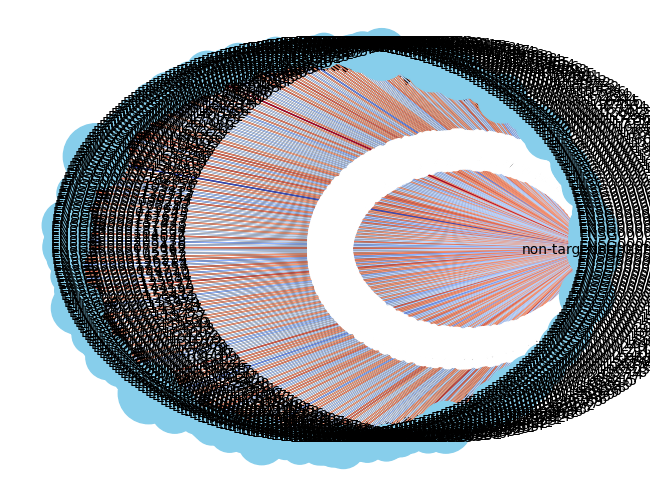

In [302]:
plot_network(
    trans_res_guide_sig,
    central_node="non-targeting_03783",
    source_column="guide_id",
    target_column="gene_id",
    weight_column="log2_fc",
    min_weight=0.5,
    node_size_column="-log10_pvalue",
)

/tmp/ipykernel_1779256/3395261460.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


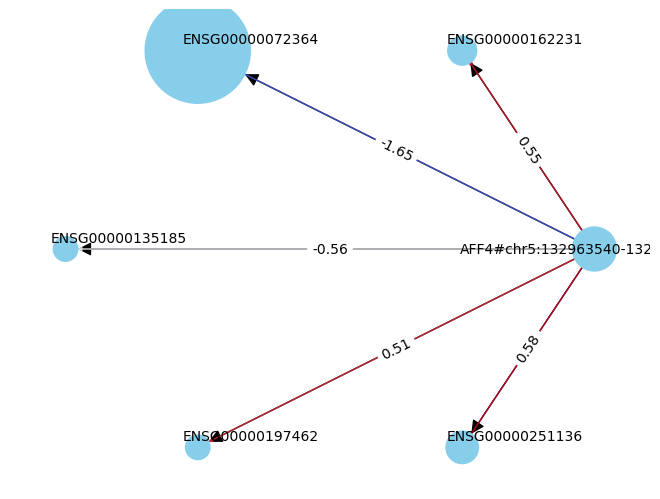

In [300]:
plot_network(
    trans_res_guide_sig,
    central_node="AFF4#chr5:132963540-132963558(+)",
    source_column="guide_id",
    target_column="gene_id",
    weight_column="log2_fc",
    min_weight=0.5,
    node_size_column="-log10_pvalue",
)